In [1]:
import logging
import os
import random
from collections import Counter
# from importlib import reload

import anndata
import numpy as np
import pandas as pd
import scanpy as sc
# import matplotlib.pyplot as plt

import pollock
import pollock.models.analysis as pollock_analysis
from pollock.models.model import PollockDataset, PollockModel, load_from_directory

/home/estorrs/miniconda3/envs/pollock/lib/python3.7/site-packages/anndata/_core/anndata.py:21: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex


In [2]:
%load_ext autoreload

In [3]:
%autoreload 2

## Read in data

In [4]:
expression_matrix_filepath = '/home/estorrs/data/single_cell_classification/scRNAseq_benchmark/Intra-dataset/Zheng sorted/Filtered_DownSampled_SortedPBMC_data.csv'
label_filepath = '/home/estorrs/data/single_cell_classification/scRNAseq_benchmark/Intra-dataset/Zheng sorted/Labels.csv'
model_filepath = '/home/estorrs/pollock/models/zheng_sorted/'


In [13]:
expression_matrix_filepath = '/home/estorrs/data/single_cell_classification/scRNAseq_benchmark/Intra-dataset/TM/Filtered_TM_data.csv'
label_filepath = '/home/estorrs/data/single_cell_classification/scRNAseq_benchmark/Intra-dataset/TM/Labels.csv'
model_filepath = '/home/estorrs/pollock/models/tm_filtered/'


In [14]:
expression_df = pd.read_csv(expression_matrix_filepath)
expression_df

,Unnamed: 0,Xkr4,Rp1,Sox17,Mrpl15,Lypla1,Tcea1,Rgs20,Atp6v1h,Oprk1,...,Uty,Ddx3y,Usp9y,Rbmy1a1,LOC100040223,LOC434960,LOC380994,LOC100041346,Sly,Erdr1
0,10X_P4_3_AAAGTAGAGATGCCAG,0,0,0,1,0,0,0,0,0,...,0,2,0,0,0,0,0,0,0,0
1,10X_P4_3_AACCGCGTCCAACCAA,0,0,0,0,2,3,0,0,0,...,0,1,0,0,0,0,0,0,0,1
2,10X_P4_3_AACTCCCGTCGGGTCT,0,0,0,0,1,1,0,2,0,...,0,4,0,0,0,0,0,0,0,0
3,10X_P4_3_AACTCTTAGTTGCAGG,0,0,0,0,2,0,0,1,0,...,0,1,0,0,0,0,0,0,0,1
4,10X_P4_3_AACTCTTTCATAACCG,0,0,0,0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54860,10X_P8_15_TTTGTCAGTTGTCGCG,0,0,0,0,0,0,0,1,0,...,0,1,0,0,0,0,0,0,0,0
54861,10X_P8_15_TTTGTCATCACGATGT,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
54862,10X_P8_15_TTTGTCATCGGCTTGG,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
54863,10X_P8_15_TTTGTCATCTTACCGC,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [15]:
## set index to cell id
expression_df = expression_df.set_index('Unnamed: 0')
expression_df

,Xkr4,Rp1,Sox17,Mrpl15,Lypla1,Tcea1,Rgs20,Atp6v1h,Oprk1,Npbwr1,...,Uty,Ddx3y,Usp9y,Rbmy1a1,LOC100040223,LOC434960,LOC380994,LOC100041346,Sly,Erdr1
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
10X_P4_3_AAAGTAGAGATGCCAG,0,0,0,1,0,0,0,0,0,0,...,0,2,0,0,0,0,0,0,0,0
10X_P4_3_AACCGCGTCCAACCAA,0,0,0,0,2,3,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1
10X_P4_3_AACTCCCGTCGGGTCT,0,0,0,0,1,1,0,2,0,0,...,0,4,0,0,0,0,0,0,0,0
10X_P4_3_AACTCTTAGTTGCAGG,0,0,0,0,2,0,0,1,0,0,...,0,1,0,0,0,0,0,0,0,1
10X_P4_3_AACTCTTTCATAACCG,0,0,0,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10X_P8_15_TTTGTCAGTTGTCGCG,0,0,0,0,0,0,0,1,0,0,...,0,1,0,0,0,0,0,0,0,0
10X_P8_15_TTTGTCATCACGATGT,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10X_P8_15_TTTGTCATCGGCTTGG,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [16]:
groundtruth_label_df = pd.read_csv(label_filepath)
groundtruth_label_df

,x
0,bladder cell
1,bladder cell
2,bladder cell
3,bladder urothelial cell
4,bladder cell
...,...
54860,endothelial cell
54861,blood cell
54862,endothelial cell
54863,mesenchymal cell


set up anndata object (this is the same object that scanpy works off of, and is similar to a SeuratObject)

In [17]:
adata = anndata.AnnData(X=expression_df.values)
adata.var.index = expression_df.columns
adata

AnnData object with n_obs × n_vars = 54865 × 19791 

In [18]:
adata.var

""
Xkr4
Rp1
Sox17
Mrpl15
Lypla1
...
LOC434960
LOC380994
LOC100041346
Sly


## predict cell types

In [20]:
pollock_dataset, model = load_from_directory(adata, model_filepath,
        image_root_dir=os.path.join('/home/estorrs/pollock/models', 'scratch', 'test_prediction'))

2020-02-18 14:42:04,885 writing images
2020-02-18 14:42:04,886 0 cell images written
/home/estorrs/pollock/pollock/models/model.py:243: RuntimeWarning: divide by zero encountered in log2
  expression = np.log2(X[i])
2020-02-18 14:42:07,383 1000 cell images written
2020-02-18 14:42:10,002 2000 cell images written
2020-02-18 14:42:12,489 3000 cell images written
2020-02-18 14:42:14,991 4000 cell images written
2020-02-18 14:42:17,542 5000 cell images written
2020-02-18 14:42:20,132 6000 cell images written
2020-02-18 14:42:22,640 7000 cell images written
2020-02-18 14:42:26,358 8000 cell images written
2020-02-18 14:42:28,838 9000 cell images written
2020-02-18 14:42:31,368 10000 cell images written
2020-02-18 14:42:33,964 11000 cell images written
2020-02-18 14:42:36,569 12000 cell images written
2020-02-18 14:42:39,255 13000 cell images written
2020-02-18 14:42:41,855 14000 cell images written
2020-02-18 14:42:44,488 15000 cell images written
2020-02-18 14:42:47,007 16000 cell images w

Found 54865 images belonging to 1 classes.


#### view model summary

each model comes with a summary.json file that contains information about each model

In [21]:
model.summary.keys()

dict_keys(['dataset', 'model_training', 'history', 'validation', 'training'])

In [27]:
model.summary['dataset']['cell_types']

['B cell',
 'DN1 thymic pro-T cell',
 'Fraction A pre-pro B cell',
 'Langerhans cell',
 'T cell',
 'alveolar macrophage',
 'basal cell',
 'basal cell of epidermis',
 'basophil',
 'bladder cell',
 'bladder urothelial cell',
 'blood cell',
 'cardiac muscle cell',
 'ciliated columnar cell of tracheobronchial tree',
 'classical monocyte',
 'dendritic cell',
 'duct epithelial cell',
 'early pro-B cell',
 'endocardial cell',
 'endothelial cell',
 'endothelial cell of hepatic sinusoid',
 'epithelial cell',
 'erythroblast',
 'fibroblast',
 'granulocyte',
 'granulocytopoietic cell',
 'hematopoietic precursor cell',
 'hepatocyte',
 'immature B cell',
 'immature T cell',
 'keratinocyte',
 'kidney capillary endothelial cell',
 'kidney cell',
 'kidney collecting duct epithelial cell',
 'kidney loop of Henle ascending limb epithelial cell',
 'kidney proximal straight tubule epithelial cell',
 'late pro-B cell',
 'leukocyte',
 'luminal epithelial cell of mammary gland',
 'lung endothelial cell',
 'ma

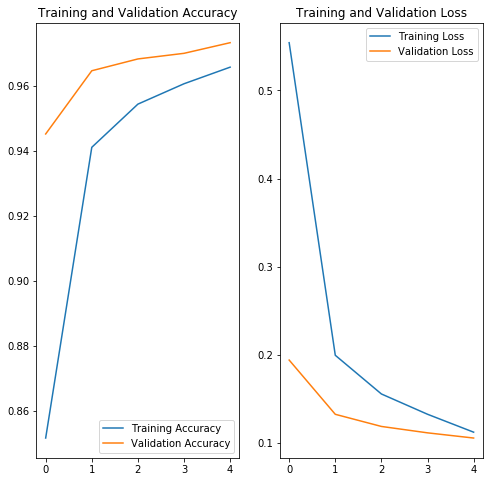

In [30]:
pollock_analysis.show_history(model.summary['history'], from_dict=True)

In [31]:
probs = model.predict_pollock_dataset(pollock_dataset)
probs.shape

(54865, 55)

In [33]:
probability_df = pd.DataFrame(data=probs, columns=pollock_dataset.cell_types, index=expression_df.index)
probability_df

,B cell,DN1 thymic pro-T cell,Fraction A pre-pro B cell,Langerhans cell,T cell,alveolar macrophage,basal cell,basal cell of epidermis,basophil,bladder cell,...,monocyte,myeloid cell,natural killer cell,neuroendocrine cell,non-classical monocyte,proerythroblast,promonocyte,skeletal muscle satellite cell,stromal cell,type II pneumocyte
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
10X_P4_3_AAAGTAGAGATGCCAG,2.056898e-12,5.597865e-12,1.479833e-12,1.757366e-12,3.304048e-08,2.427364e-09,2.578650e-11,1.231886e-10,7.624565e-13,9.999602e-01,...,2.352428e-11,6.898739e-09,2.184053e-10,8.647493e-10,2.239671e-09,1.347238e-13,1.200699e-11,5.134955e-10,3.899536e-05,6.415396e-10
10X_P4_3_AACCGCGTCCAACCAA,7.186496e-11,9.607611e-11,4.033436e-11,1.360208e-11,1.387839e-07,1.054937e-08,6.597745e-11,7.151236e-10,2.634693e-11,9.999651e-01,...,1.458367e-10,4.345671e-08,7.024863e-09,1.881848e-09,6.851592e-09,3.264188e-12,1.716241e-10,1.639243e-09,2.850471e-05,1.227184e-08
10X_P4_3_AACTCCCGTCGGGTCT,1.813696e-04,1.550649e-05,1.338475e-06,2.930970e-05,2.181090e-04,1.351342e-04,5.223262e-06,1.077463e-04,3.088342e-06,1.515965e-03,...,1.005402e-05,5.083520e-05,2.125089e-05,1.089019e-05,1.478392e-05,1.491254e-06,5.011673e-06,1.851710e-05,3.999391e-04,1.056927e-04
10X_P4_3_AACTCTTAGTTGCAGG,5.250633e-09,1.730719e-09,1.079334e-12,2.876807e-10,2.098919e-07,1.129999e-08,5.038077e-12,4.739853e-09,2.241885e-12,3.843764e-08,...,1.591184e-12,3.733748e-08,4.236691e-11,5.627783e-12,4.969946e-10,6.761005e-13,4.797374e-12,4.489550e-11,7.464809e-08,7.597128e-08
10X_P4_3_AACTCTTTCATAACCG,7.711126e-12,2.236374e-12,1.751584e-12,5.339385e-12,7.875935e-10,1.960927e-11,1.148459e-11,2.475396e-10,2.177248e-12,9.999990e-01,...,5.418515e-12,8.445141e-12,2.907996e-11,1.523119e-08,1.481968e-11,1.317063e-12,1.730730e-11,2.185796e-10,9.522111e-07,3.125279e-11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10X_P8_15_TTTGTCAGTTGTCGCG,1.489807e-05,2.910466e-08,2.018202e-07,1.774055e-06,1.831551e-05,1.570513e-04,1.978529e-08,9.628618e-08,1.646821e-06,3.033944e-07,...,2.021708e-05,1.058148e-04,2.213188e-05,4.263905e-06,2.565435e-06,1.393082e-07,3.231644e-07,8.421809e-08,7.049663e-06,7.243615e-06
10X_P8_15_TTTGTCATCACGATGT,4.236939e-13,2.963025e-18,1.582224e-16,8.092507e-15,9.383252e-14,3.499612e-13,1.033937e-16,5.207363e-16,2.501189e-17,9.158016e-16,...,4.692465e-14,1.891065e-12,6.095853e-13,3.416561e-14,1.073560e-14,5.916744e-15,2.259697e-16,1.976801e-16,5.552702e-12,1.244687e-14
10X_P8_15_TTTGTCATCGGCTTGG,9.396425e-12,2.851168e-16,1.317887e-14,2.387311e-13,9.257560e-12,1.132705e-11,1.411079e-14,1.592878e-14,7.961120e-15,7.714714e-14,...,1.146978e-11,7.980428e-11,5.956715e-11,5.826877e-12,7.243202e-13,3.855172e-13,5.021142e-14,1.765110e-14,6.613248e-10,4.428069e-13


In [38]:
m = np.arange(16).reshape((4,4)).astype(np.uint8)
m

array([[ 0,  1,  2,  3],
       [ 4,  5,  6,  7],
       [ 8,  9, 10, 11],
       [12, 13, 14, 15]], dtype=uint8)

In [36]:
import cv2

In [40]:
resized = cv2.resize(m, (16,16), interpolation = cv2.INTER_AREA)
resized

array([[ 0,  0,  0,  0,  1,  1,  1,  1,  2,  2,  2,  2,  3,  3,  3,  3],
       [ 0,  0,  0,  0,  1,  1,  1,  1,  2,  2,  2,  2,  3,  3,  3,  3],
       [ 0,  0,  0,  0,  1,  1,  1,  1,  2,  2,  2,  2,  3,  3,  3,  3],
       [ 0,  0,  0,  0,  1,  1,  1,  1,  2,  2,  2,  2,  3,  3,  3,  3],
       [ 4,  4,  4,  4,  5,  5,  5,  5,  6,  6,  6,  6,  7,  7,  7,  7],
       [ 4,  4,  4,  4,  5,  5,  5,  5,  6,  6,  6,  6,  7,  7,  7,  7],
       [ 4,  4,  4,  4,  5,  5,  5,  5,  6,  6,  6,  6,  7,  7,  7,  7],
       [ 4,  4,  4,  4,  5,  5,  5,  5,  6,  6,  6,  6,  7,  7,  7,  7],
       [ 8,  8,  8,  8,  9,  9,  9,  9, 10, 10, 10, 10, 11, 11, 11, 11],
       [ 8,  8,  8,  8,  9,  9,  9,  9, 10, 10, 10, 10, 11, 11, 11, 11],
       [ 8,  8,  8,  8,  9,  9,  9,  9, 10, 10, 10, 10, 11, 11, 11, 11],
       [ 8,  8,  8,  8,  9,  9,  9,  9, 10, 10, 10, 10, 11, 11, 11, 11],
       [12, 12, 12, 12, 13, 13, 13, 13, 14, 14, 14, 14, 15, 15, 15, 15],
       [12, 12, 12, 12, 13, 13, 13, 13, 14, 14, 14,